## Running topic modelling

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk                         # used to preprocess data to insert in topic modelling algorithm
import gensim                       # used to run the topic modelling

import pyLDAvis                     # used to visualise topic modelling results
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
/usr/local/lib/python3.6/dist-packages/paramiko/transport.py:33: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography.hazmat.backends import default_backend


In [2]:
def tokenize(docs, tokenizer):
    """Tokenize documents, turning string of text in list of words

    Parameters:
    docs (pandas.series): pandas series, each element is one string with title, keyword and abstract of one document.
    tokenizer (nltk.RegexpTokenizer): nltk tokenizer with regex to define how to break string into words.

    Returns:
    list: list of list of strings. Each list of strings contains words of one document.

   """
    docs = [doc.lower() for doc in docs]
    docs = [tokenizer.tokenize(doc) for doc in docs]
    docs = [[d.strip() for d in doc if d.strip()] for doc in docs]
    docs = [' '.join(doc).split(' ') for doc in docs]
    
    return docs

def clen_words(docs, stopwords=set()):
    """Remove stopwords of documents based on method input.

    Parameters:
    docs (list): list of list of strings. Each list of strings contains words of one document.
    stopwords (list): list of stopwords words that should not be passed to topic modelling algorithm.

    Returns:
    list: list of list of strings. Each list of strings contains words of one document.

   """
    bag = [[word for word in doc if valid_word(word, stopwords)] for doc in docs]  
    
    return bag

def valid_word(word, stopwords):
    """Check if a word is valid, used inside clen_words.

    Parameters:
    word (string): Word of one document.
    stopwords (list): list of stopwords words that should not be passed to topic modelling algorithm.

    Returns:
    bool: True if the word is valid and False if the word is not valid.

   """
    return (word not in stopwords and len(word) >= 3 and not word.isnumeric())

def lemmatize(docs, lemmatizer):
    """Lemmatize documents, when necessary replacing words for its lemmas.

    Parameters:
    docs (list): list of list of strings. Each list of strings contains words of one document.
    lemmatizer (nltk.WordNetLemmatizer): object that lemmatize strings.

    Returns:
    list: list of list of strings. Each list of strings contains words of one document.

   """
    return [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [3]:
# Import data and define initial documents
df = pd.read_csv('data/modelling.csv', index_col=0)

# Fill empty Author Keywords values with empty string
df['author_keywords'] = df['author_keywords'].fillna('')
df['abstract'] = df['abstract'].fillna('')

# Make Year and number of citations a integer
df['year'] = df['year'].astype('Int64')
df['number_citation'] = df['number_citation'].astype('Int64')

# Define docs
docs = df['title'] + ' ' + df['abstract'] + ' ' + df['author_keywords']

In [4]:
# Preprocess and clean documents

tokenizer = nltk.tokenize.RegexpTokenizer(r'[\w|\-]+')
docs = tokenize(docs, tokenizer)

new_stopwords = ['research', 'review', 'literature', 'analysis']
stopwords = nltk.corpus.stopwords.words('english') + new_stopwords
docs = clen_words(docs, stopwords)

lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
docs = lemmatize(docs, lemmatizer)

In [5]:
# Add bigrams - sequence of two words - to documents
bigram = gensim.models.Phrases(docs, min_count=30)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            docs[idx].append(token)

In [6]:
# Set parameters of the model
no_below=70; no_above=0.5; keep_n=7000; num_topics = 5; passes=10; iterations=5000; random_state=6
#no_below=70; no_above=0.5; keep_n=7000; num_topics = 5; passes=10; iterations=5000; random_state=4

# Create dictionary based on documents and define the corpus
dictionary = gensim.corpora.Dictionary(docs)
dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=keep_n)

corpus = [dictionary.doc2bow(doc) for doc in docs]

# Fit LDA topic model
LDA_model = gensim.models.LdaModel(corpus, id2word=dictionary, passes=passes, 
                                   chunksize=5000, iterations=iterations,
                                   num_topics=num_topics, eval_every=None, random_state=random_state)

# Print results
topics_matrix = LDA_model.show_topics(formatted=False, num_words=7)
for i in topics_matrix:
    print(f'Topic {i[0] + 1}: {[str(pair[0]) for pair in i[1]]}')
    
# Compute model coherence
coherecenmodel = gensim.models.coherencemodel.CoherenceModel(model=LDA_model, texts=docs, coherence='c_v')
print(f'Model coherece {coherecenmodel.get_coherence()}')

Topic 1: ['health', 'stress', 'factor', 'social', 'psychological', 'effect', 'mental']
Topic 2: ['risk', 'system', 'urban', 'vulnerability', 'flood', 'assessment', 'disaster']
Topic 3: ['change', 'climate', 'ecosystem', 'water', 'specie', 'forest', 'climate_change']
Topic 4: ['system', 'network', 'energy', 'performance', 'proposed', 'power', 'method']
Topic 5: ['supply', 'chain', 'social', 'supply_chain', 'management', 'covid-19', 'impact']
Model coherece 0.5260404916465486


In [7]:
# Visualize results
roots_data = pyLDAvis.gensim.prepare(LDA_model, corpus, dictionary)
pyLDAvis.display(roots_data)

## Selecting papers inside topic model

In [8]:
# Based on the result of the topic modelling, fill topic for each paper
df['topic'] = 0
for idx in range(len(corpus)):
    topic_number = sorted(LDA_model[corpus[idx]], reverse=True, key=lambda element: element[1])[0][0] + 1
    df.loc[idx, 'topic'] = int(topic_number)

df[['title', 'journal_name', 'topic']].assign(tokens=docs).head()

,title,journal_name,topic,tokens
index,,,,
0,Resiliency programming for adult offenders in ...,Education and urban society,5,"[resiliency, programming, adult, offender, geo..."
1,The resilience of changes promoting inclusiven...,Elementary school journal,1,"[resilience, change, promoting, inclusiveness,..."
2,Integrated geographical assessment of environm...,Journal of environmental management,3,"[integrated, geographical, assessment, environ..."
3,Understanding the role of sink patches in sour...,Conservation biology,3,"[understanding, role, sink, patch, source-sink..."
4,Ecosystem stability and resilience: A review o...,"Perspectives in plant ecology, evolution and s...",3,"[ecosystem, stability, resilience, relevance, ..."


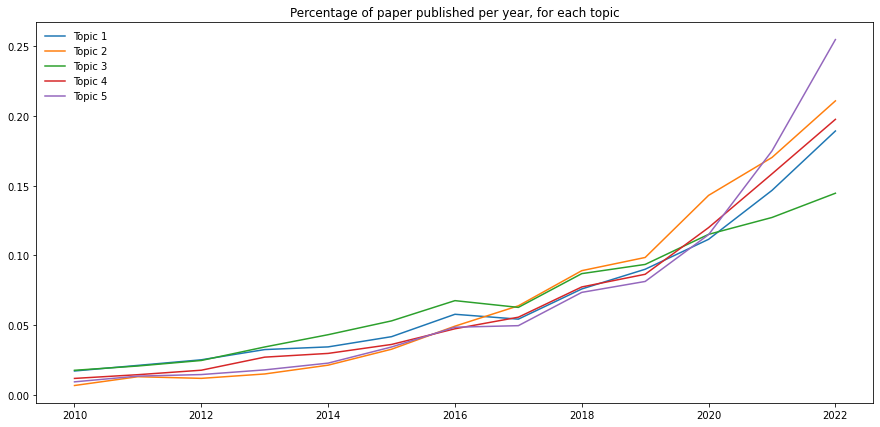

In [9]:
# Plot percentage of publication per year, inside topic
sns.set_context(rc = {'patch.linewidth': 0.0})
plt.figure(figsize=(15, 7))

years = np.arange(2010, 2023)
for topic in range(num_topics):
    dfTopic = df[df['topic'] == topic + 1]
    total_num_results = len(dfTopic)
    num_results = [(dfTopic['year'] == year).sum() / total_num_results for year in years] 
    sns.lineplot(x=years, y=num_results, label=f"Topic {topic + 1}") 

plt.title('Percentage of paper published per year, for each topic')
plt.legend()
plt.show()

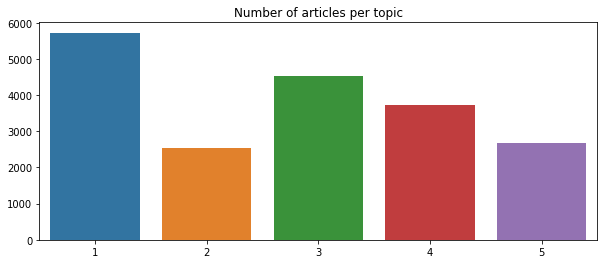

In [10]:
# Plot bar chart of the number of papers in each topic
plt.figure(figsize=(10, 4))

group_size = [len(group) for name, group in df.groupby('topic')]
topic = np.arange(0, num_topics) + 1
sns.barplot(x=topic, y=group_size)

plt.title('Number of articles per topic')
plt.show()

In [11]:
# Print the most frequent journal per topic
number_journals = 10
topics_dictionary = ['Health psychology', 'Urban disaster', 'Ecological biological', 'Energy power-grid', 'Supply-chain organizational']

topic_data = {}
for topic in range(num_topics):
    dfTopic = df[df['topic'] == topic + 1]
    dfJournalCount = dfTopic['journal_name'].value_counts().head(number_journals)
    topic_data[f'{topics_dictionary[topic]}'] = list(dfJournalCount.index)
    #topic_data[f'{topic + 1} ({topics_dictionary[topic]}) percentage'] = list(dfJournalCount.values / len(dfTopic)) 

dfTopic = pd.DataFrame(topic_data)
dfTopic

,Health psychology,Urban disaster,Ecological biological,Energy power-grid,Supply-chain organizational
0,Frontiers in psychology,Sustainability,Science of the total environment,Ieee access,Sustainability
1,Plos one,International journal of disaster risk reduction,Plos one,Reliability engineering and system safety,Plos one
2,International journal of environmental researc...,Natural hazards,Ecological indicators,Ieee transactions on smart grid,International journal of environmental researc...
3,Journal of affective disorders,Reliability engineering and system safety,Forest ecology and management,Engineering structures,International journal of production research
4,Frontiers in psychiatry,Journal of cleaner production,Global change biology,Ieee transactions on power systems,International journal of disaster risk reduction
5,Current psychology,Water (switzerland),Ecological applications,Energies,Ecology and society
6,Children and youth services review,International journal of environmental researc...,Scientific reports,Applied energy,Journal of cleaner production
7,Bmj open,Ecological indicators,Ecological modelling,Ieee systems journal,Frontiers in psychology
8,Personality and individual differences,Sustainable cities and society,Ecosphere,International journal of electrical power and ...,International journal of production economics
9,Bmc public health,Science of the total environment,Frontiers in marine science,Sensors,International journal of logistics management


In [12]:
sample_journals = ['Frontiers in psychology', 'Frontiers in psychiatry',
                   'Sustainable cities and society', 'Risk analysis', 'Reliability engineering and system safety',
                     'International journal of disaster risk reduction',          
                   'Ecological indicators', 'Ecological applications', 'Journal of hydrology', 
                     'Global change biology', 'Environmental research letters', 
                     'Frontiers in marine science', 'Forest ecology and management', 
                   'Ieee transactions on smart grid', 'Ieee systems journal', 'Water resources management', 
                   'International journal of production research', 'Ecology and society']

journal_data = []
for journal_name in sample_journals:
    dfJournal = df[df['journal_name'] == journal_name]
    group_topic = dfJournal[['title', 'topic']].groupby(['topic']).count().sort_values(by=['title'], ascending=False)
    main_topic = group_topic.index[0]
    percentage  = round(100 * group_topic.iloc[0,0] / len(dfJournal), 2)
    journal_data.append([journal_name, main_topic, topics_dictionary[main_topic-1], percentage])

columns = ['Journal Name', 'Main Topic Number', 'Main Topic Name', 'Percentage of Paper in main topic']
dfJournal = pd.DataFrame(journal_data, columns=columns)
dfJournal

,Journal Name,Main Topic Number,Main Topic Name,Percentage of Paper in main topic
0,Frontiers in psychology,1,Health psychology,87.43
1,Frontiers in psychiatry,1,Health psychology,94.44
2,Sustainable cities and society,2,Urban disaster,60.66
3,Risk analysis,2,Urban disaster,61.11
4,Reliability engineering and system safety,2,Urban disaster,48.21
5,International journal of disaster risk reduction,2,Urban disaster,72.50
6,Ecological indicators,3,Ecological biological,68.06
7,Ecological applications,3,Ecological biological,100.00
8,Journal of hydrology,3,Ecological biological,60.23
9,Global change biology,3,Ecological biological,100.00


In [13]:
# Save dataset of journals that will be tested to analyse inclusion criteria.

sample_journals = ['Frontiers in psychiatry', 'Frontiers in psychology',
                 'Sustainable cities and society', 'Reliability engineering and system safety',
                 'Ecological applications', 'Global change biology', 'Ecological indicators', 'Environmental research letters',
                 'Ieee transactions on smart grid', 'Water resources management', 
                 'International journal of production research', 'Ecology and society'
                ]

# Saving csv with most cited and newer papers per topic
dfReduced = df.drop(columns=['abstract', 'references'])
dfReduced['Included?'] = dfReduced['Reason'] = ''

with pd.ExcelWriter("data/test_modelling_papers_journal.xlsx") as writer:
    for journal_name in sample_journals:
        dfJournal = dfReduced[dfReduced['journal_name'] == journal_name]
        dfJournal = dfJournal.sort_values(by=['number_citation'], ascending=False, na_position='last')
        dfJournal.to_excel(writer, sheet_name=f'{journal_name}', index=False)

/home/vitor/.local/lib/python3.6/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


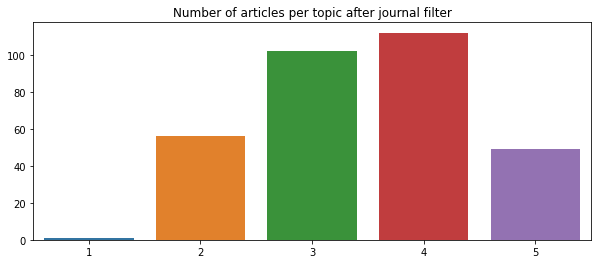

In [14]:
# Plot bar chart of the number of papers in each topic after journal filter
plt.figure(figsize=(10, 4))

selected_journals = ['Sustainable cities and society', 
                     'Global change biology',
                     'Ieee transactions on smart grid', 
                     'International journal of production research',
                     'Water resources management'
                    ] 

dfReduced = df.drop(columns=['abstract', 'references'])
dfReduced['Included?'] = dfReduced['Reason'] = ''
dfReduced = dfReduced[dfReduced['journal_name'].isin(selected_journals)]

group_size = [len(group) for name, group in dfReduced.groupby('topic')]
topic = np.arange(0, num_topics) + 1
sns.barplot(x=topic, y=group_size)

plt.title('Number of articles per topic after journal filter')
plt.show()

In [15]:
# Save final dataset with selected journals

total_papers_selected = 0
for journal_name in selected_journals:
    dfJournal = df[df['journal_name'] == journal_name]
    total_papers_selected += len(dfJournal)
    print(f'There are {len(dfJournal)} papers of the journal {journal_name}.')
print(f'The total number of articles is {len(df)}, {total_papers_selected} are in the selected journals ' \
      f'({round(100 * total_papers_selected / len(df), 1)}%)')

# Saving csv with most cited and newer papers per topic
dfReduced = df.drop(columns=['abstract', 'references'])
dfReduced['Included?'] = dfReduced['Reason'] = ''

with pd.ExcelWriter("data/modelling_papers_journal.xlsx") as writer:
    for journal_name in selected_journals:
        dfJournal = dfReduced[dfReduced['journal_name'] == journal_name]
        dfJournal = dfJournal.sort_values(by=['number_citation'], ascending=False, na_position='last')
        dfJournal.to_excel(writer, sheet_name=f'{journal_name}', index=False)

There are 61 papers of the journal Sustainable cities and society.
There are 80 papers of the journal Global change biology.
There are 67 papers of the journal Ieee transactions on smart grid.
There are 59 papers of the journal International journal of production research.
There are 53 papers of the journal Water resources management.
The total number of articles is 19214, 320 are in the selected journals (1.7%)


/home/vitor/.local/lib/python3.6/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
